In [22]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, Resizing, Rescaling
from sklearn.cluster import KMeans

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import shutil

In [23]:
# Extract data
X = np.load('Xtrain_Classification_Part2.npy')
y = np.load('Ytrain_Classification_Part2.npy')

X_train, X_validate, train_labels, test_labels = train_test_split(X,y)


In [24]:
class_names = ['caucasian', 'african', 'asian', 'indian']

# Reshape to 50x50 pixel images
pixels = 50
train_images = []
test_images = []

for image in X_train:
    train_images.append(image.reshape(pixels, pixels))

for image in X_validate:
    test_images.append(image.reshape(pixels, pixels))

train_images = np.array(train_images)
test_images = np.array(test_images)

In [25]:
# Normalizing
train_images = train_images / 255.0
test_images = test_images / 255.0

X_train = X_train / 255.0
X_validate = X_validate / 255.0

In [26]:
# Data augmentation

data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.2),
  RandomZoom(0.1),
])



In [27]:
caucasian_count = 0
african_count = 0
asian_count = 0
indian_count = 0

caucasian_train = []

for index, label in enumerate(train_labels):
    if label == 0:
        caucasian_count += 1
        caucasian_train.append(train_images[index])
    elif label == 1:
        african_count += 1
    elif label == 2:
        asian_count += 1
    elif label == 3:
        indian_count += 1

In [28]:
# Extract features from data

def image_feature(images):
    features = []
    pixels = 50

    for img in images:
        pix = img.reshape(pixels*pixels)
        features.append(pix)
        
    return features

In [29]:
# Cluster Caucasian images in training data

k = max(african_count, max(asian_count, indian_count))
clusters = KMeans(n_clusters = k, max_iter = 100, n_init = 5, random_state = 20)
print(len(image_feature(caucasian_train)))
print(image_feature(caucasian_train)[0].shape)
clusters.fit(image_feature(caucasian_train))

caucasian_clusters = clusters.cluster_centers_

3359
(2500,)


In [30]:
caucasian_train = np.array(caucasian_train)
reshaped_data = caucasian_train.reshape(len(caucasian_train),-1)

clusters_caucasian = clusters.fit_predict(reshaped_data)

In [31]:
clusters_caucasian = clusters.cluster_centers_
clusters_caucasian.shape

(989, 2500)

In [32]:
# Update training set
#pixels = 50

new_train_images = []
new_train_labels = []

caucasian_count = 0

caucasian_images = []

for image in clusters_caucasian:
    caucasian_images.append(image.reshape(pixels, pixels))

caucasian_images = np.array(caucasian_images)
print(caucasian_images.shape)

for index, label in enumerate(train_labels):
    if label != 0:
        new_train_images.append(train_images[index].reshape(pixels,pixels))
        #print(train_images[index].reshape(pixels,pixels))
        new_train_labels.append(label)
    elif caucasian_count < len(caucasian_images):
        new_train_images.append(caucasian_images[caucasian_count].reshape(pixels,pixels))
        new_train_labels.append(label)
        caucasian_count += 1

print(new_train_images[0].shape)

#new_train_images = np.reshape(new_train_images, (len(new_train_images), 50, 50))

new_train_images = np.array(new_train_images)


(989, 50, 50)
(50, 50)


In [33]:
# Building CNN Model
model = keras.Sequential()
#model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(50, 50, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation="softmax"))

In [34]:
model.compile(  optimizer='adam',
                loss = 'sparse_categorical_crossentropy', #'binary_crossentropy',
                metrics = ['accuracy'])

In [35]:
# Train model
#train_images = np.reshape(train_images, (len(train_images), 50, 50, 1))
test_images = np.reshape(test_images, (len(test_images),50, 50, 1))
test_images = np.asarray(test_images)

new_train_images = np.reshape(new_train_images, (len(new_train_images), 50, 50, 1))
new_train_images = np.asarray(new_train_images)

new_train_labels = np.asarray(new_train_labels)
#print(type(new_train_images))
#print(type(train_images))
history = model.fit(new_train_images, new_train_labels, validation_data = (test_images, test_labels), epochs = 10)

Epoch 1/10
99/99 [==============================] - 11s 110ms/step - loss: 1.2762 - accuracy: 0.3719 - val_loss: 1.1403 - val_accuracy: 0.4658
Epoch 2/10
99/99 [==============================] - 10s 105ms/step - loss: 1.0663 - accuracy: 0.5415 - val_loss: 0.9533 - val_accuracy: 0.6189
Epoch 3/10
99/99 [==============================] - 11s 107ms/step - loss: 0.8983 - accuracy: 0.6367 - val_loss: 0.8500 - val_accuracy: 0.6612
Epoch 4/10
99/99 [==============================] - 11s 106ms/step - loss: 0.7767 - accuracy: 0.6985 - val_loss: 0.8257 - val_accuracy: 0.6846
Epoch 5/10
99/99 [==============================] - 11s 111ms/step - loss: 0.6844 - accuracy: 0.7378 - val_loss: 0.8158 - val_accuracy: 0.6650
Epoch 6/10
99/99 [==============================] - 12s 119ms/step - loss: 0.6365 - accuracy: 0.7720 - val_loss: 0.7142 - val_accuracy: 0.7400
Epoch 7/10
99/99 [==============================] - 13s 130ms/step - loss: 0.5678 - accuracy: 0.7974 - val_loss: 0.5846 - val_accuracy: 0.7904

In [36]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 50, 50, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)       

In [37]:
# Accuracy
test_images = test_images.reshape(-1, 50, 50, 1)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

58/58 [==============================] - 1s 22ms/step - loss: 0.7250 - accuracy: 0.7438
Test accuracy: 0.7437567710876465


In [38]:
predictions = model.predict(test_images) #test_images
predictions

array([[2.8791300e-03, 3.1154034e-01, 9.9800853e-03, 6.7560047e-01],
       [1.9014058e-01, 1.1275650e-02, 7.9206389e-01, 6.5197716e-03],
       [8.9259368e-01, 2.2649795e-03, 8.9046046e-02, 1.6095296e-02],
       ...,
       [9.9305660e-01, 1.8278329e-04, 7.5201318e-04, 6.0087061e-03],
       [5.7227118e-03, 2.5733381e-05, 9.9398130e-01, 2.7026632e-04],
       [6.3373959e-01, 5.5516249e-04, 1.4029022e-01, 2.2541499e-01]],
      dtype=float32)

In [39]:
# Turn predictions into labels
y_predicted = []

for i in predictions:
    y_predicted.append(np.argmax(i))

y_predicted = np.array(y_predicted)
print(y_predicted)

[3 2 0 ... 0 2 0]


BACC = 70.805906537545


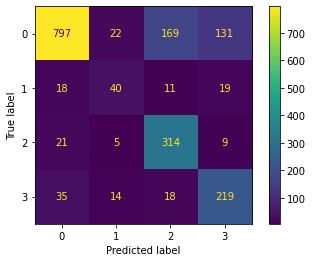

In [40]:
bacc = balanced_accuracy_score(test_labels, y_predicted)

cm = confusion_matrix(test_labels, y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
print(f"BACC = {bacc * 100}")

In [41]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                            100*np.max(predictions_array),
                                            class_names[true_label]),
                                            color = color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color = '#777777')
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

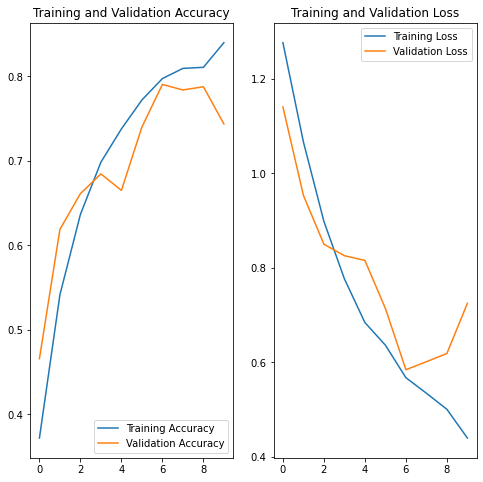

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

